# PyTorch in 12 Minutes 48 seconds

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

## Load Datasets

In [3]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 49000
NUM_VAL = 1000

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True,
                          transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)


Files already downloaded and verified
Files already downloaded and verified


For now, we're going to use a CPU-friendly datatype. Later, we'll switch to a datatype that will move all our computations to the GPU and measure the speedup.

In [32]:
dtype = torch.FloatTensor # the CPU datatype


# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

## Training a specific model



* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs
* cross-entropy loss function 
* RMSprop learning rule

In [8]:
fixed_model_base = nn.Sequential( 
                    nn.Conv2d(3, 32, kernel_size=7, stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    Flatten(),
                    nn.Linear(13*13*32, 1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024, 10)
            )

fixed_model = fixed_model_base.type(dtype)

In [9]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x = torch.randn(64, 3, 32, 32).type(dtype)
x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))       

True

## GPU


In [10]:
# Verify that CUDA is properly configured and you have a GPU available

torch.cuda.is_available()

True

In [12]:
import copy
gpu_dtype = torch.cuda.FloatTensor

fixed_model_gpu = copy.deepcopy(fixed_model_base).type(gpu_dtype)

x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
x_var_gpu = Variable(x.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))

True

Run the following cell to evaluate the performance of the forward pass running on the CPU:

In [13]:
%%timeit 
ans = fixed_model(x_var)

33.5 ms ± 532 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


... and now the GPU:

In [14]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

579 µs ± 838 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use the GPU datatype for your model and your tensors: as a reminder that is *torch.cuda.FloatTensor* (in our notebook here as *gpu_dtype*)

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the simple_model we provided above).

Make sure you understand how each PyTorch function used below corresponds to what you implemented in your custom neural network implementation.

Note that because we are not resetting the weights anywhere below, if you run the cell multiple times, you are effectively training multiple epochs (so your performance should improve).

First, set up an RMSprop optimizer (using a 1e-3 learning rate) and a cross-entropy loss function:

In [19]:
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(fixed_model_gpu.parameters(), lr=1e-3)


In [22]:
# This sets the model in "training" mode. This is relevant for some layers that may have different behavior
# in training mode vs testing mode, such as Dropout and BatchNorm. 
fixed_model_gpu.train()

# Load one batch at a time.
for t, (x, y) in enumerate(loader_train):
    x_var = Variable(x.type(gpu_dtype))
    y_var = Variable(y.type(gpu_dtype).long())

    # This is the forward pass: predict the scores for each class, for each x in the batch.
    scores = fixed_model_gpu(x_var)
    
    # Use the correct y values and the predicted y values to compute the loss.
    loss = loss_fn(scores, y_var)
    
    if (t + 1) % print_every == 0:
        print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

    # Zero out all of the gradients for the variables which the optimizer will update.
    optimizer.zero_grad()
    
    # This is the backwards pass: compute the gradient of the loss with respect to each 
    # parameter of the model.
    loss.backward()
    
    # Actually update the parameters of the model using the gradients computed by the backwards pass.
    optimizer.step()

/home/deep/miniconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 1.3351
t = 200, loss = 1.3948
t = 300, loss = 1.3110
t = 400, loss = 1.1042
t = 500, loss = 1.0459
t = 600, loss = 1.3819
t = 700, loss = 1.1677


In [24]:
val_acc = []
train_acc = []
train_loss = []
val_loss = []

kernel_size = 4
num_filter = 32
stride = 2
# 32 input size of 1 dimension
fixed_model_base = nn.Sequential( 
                    nn.Conv2d(3, 32, 3, 1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_filter),
                    nn.MaxPool2d(kernel_size=2, stride=2),
    
                    nn.Conv2d(32, 16, kernel_size=3, stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(16),
    
                    Flatten(),
                    nn.Linear((13)*(13)*16, 128),
                    nn.LeakyReLU(negative_slope=0.2),
                    nn.BatchNorm1d(128),
                    nn.Linear(128, 40),
                    nn.ReLU(inplace=True),
                    nn.Linear(40, 10)
            )

gpu_model = fixed_model_base.type(gpu_dtype)
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.Adam(gpu_model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True, patience=5)

In [25]:
def train(model, loss_fn, optimizer, num_epochs=1):
    max_val_acc = 0
    early_stop_counter = 0
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        # enumerate(loader_train) -> operate on minibatch
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        early_stop_counter += 1    
        v_loss, v_acc = check_accuracy(gpu_model, loader_val, 'validation')
        val_acc.append(v_acc)
        val_loss.append(v_loss)
        t_loss, t_acc = check_accuracy(gpu_model, loader_train, 'train')
        train_acc.append(t_acc)
        train_loss.append(t_loss)
        if v_acc > max_val_acc:
            max_val_acc = v_acc
            early_stop_counter = 0
        if early_stop_counter == 10:
            print('stop early counter:', early_stop_counter)
            break
        scheduler.step(v_acc)

def check_accuracy(model, loader, set_name):
    print('Checking accuracy on ', set_name)
    num_correct = 0
    num_samples = 0
    total_loss = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        y_var = Variable(y.type(gpu_dtype).long(), volatile=True)
        scores = model(x_var)
        loss = loss_fn(scores, y_var)
        total_loss += loss.data[0]
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    mean_loss = total_loss / len(loader)
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('loss', mean_loss)
    return mean_loss, acc

In [26]:
torch.random.manual_seed(12345)
# re-initialize all our parameters
gpu_model.apply(reset)
train(gpu_model, loss_fn, optimizer, num_epochs=30)


Starting epoch 1 / 30


/home/deep/miniconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


t = 100, loss = 1.4216
t = 200, loss = 1.5142
t = 300, loss = 1.3698
t = 400, loss = 1.0534
t = 500, loss = 1.1034
t = 600, loss = 1.2430
t = 700, loss = 1.3076
Checking accuracy on  validation
Got 555 / 1000 correct (55.50)
loss tensor(1.2856, device='cuda:0')
Checking accuracy on  train


/home/deep/miniconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/deep/miniconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/deep/miniconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Got 27968 / 49000 correct (57.08)
loss tensor(1.2321, device='cuda:0')
Starting epoch 2 / 30
t = 100, loss = 1.0474
t = 200, loss = 1.1683
t = 300, loss = 1.1975
t = 400, loss = 0.8676
t = 500, loss = 0.8457
t = 600, loss = 1.0802
t = 700, loss = 1.1641
Checking accuracy on  validation
Got 535 / 1000 correct (53.50)
loss tensor(1.2973, device='cuda:0')
Checking accuracy on  train
Got 27576 / 49000 correct (56.28)
loss tensor(1.2303, device='cuda:0')
Starting epoch 3 / 30
t = 100, loss = 0.9359
t = 200, loss = 1.0274
t = 300, loss = 1.1106
t = 400, loss = 0.7955
t = 500, loss = 0.8558
t = 600, loss = 0.9662
t = 700, loss = 1.0327
Checking accuracy on  validation
Got 554 / 1000 correct (55.40)
loss tensor(1.2682, device='cuda:0')
Checking accuracy on  train
Got 27884 / 49000 correct (56.91)
loss tensor(1.2273, device='cuda:0')
Starting epoch 4 / 30
t = 100, loss = 0.9078
t = 200, loss = 0.9604
t = 300, loss = 1.0420
t = 400, loss = 0.7428
t = 500, loss = 0.8205
t = 600, loss = 0.9862
t =

t = 100, loss = 0.5552
t = 200, loss = 0.4719
t = 300, loss = 0.6665
t = 400, loss = 0.4659
t = 500, loss = 0.5711
t = 600, loss = 0.5101
t = 700, loss = 0.6652
Checking accuracy on  validation
Got 696 / 1000 correct (69.60)
loss tensor(0.8687, device='cuda:0')
Checking accuracy on  train
Got 40387 / 49000 correct (82.42)
loss tensor(0.5473, device='cuda:0')
Starting epoch 24 / 30
t = 100, loss = 0.5210
t = 200, loss = 0.4510
t = 300, loss = 0.6484
t = 400, loss = 0.4594
t = 500, loss = 0.5554
t = 600, loss = 0.4927
t = 700, loss = 0.6444
Checking accuracy on  validation
Got 694 / 1000 correct (69.40)
loss tensor(0.8752, device='cuda:0')
Checking accuracy on  train
Got 40619 / 49000 correct (82.90)
loss tensor(0.5333, device='cuda:0')
Starting epoch 25 / 30
t = 100, loss = 0.5023
t = 200, loss = 0.4381
t = 300, loss = 0.6349
t = 400, loss = 0.4480
t = 500, loss = 0.5340
t = 600, loss = 0.4789
t = 700, loss = 0.6239
Checking accuracy on  validation
Got 693 / 1000 correct (69.30)
loss te

In [28]:
%matplotlib notebook

<IPython.core.display.Javascript object>


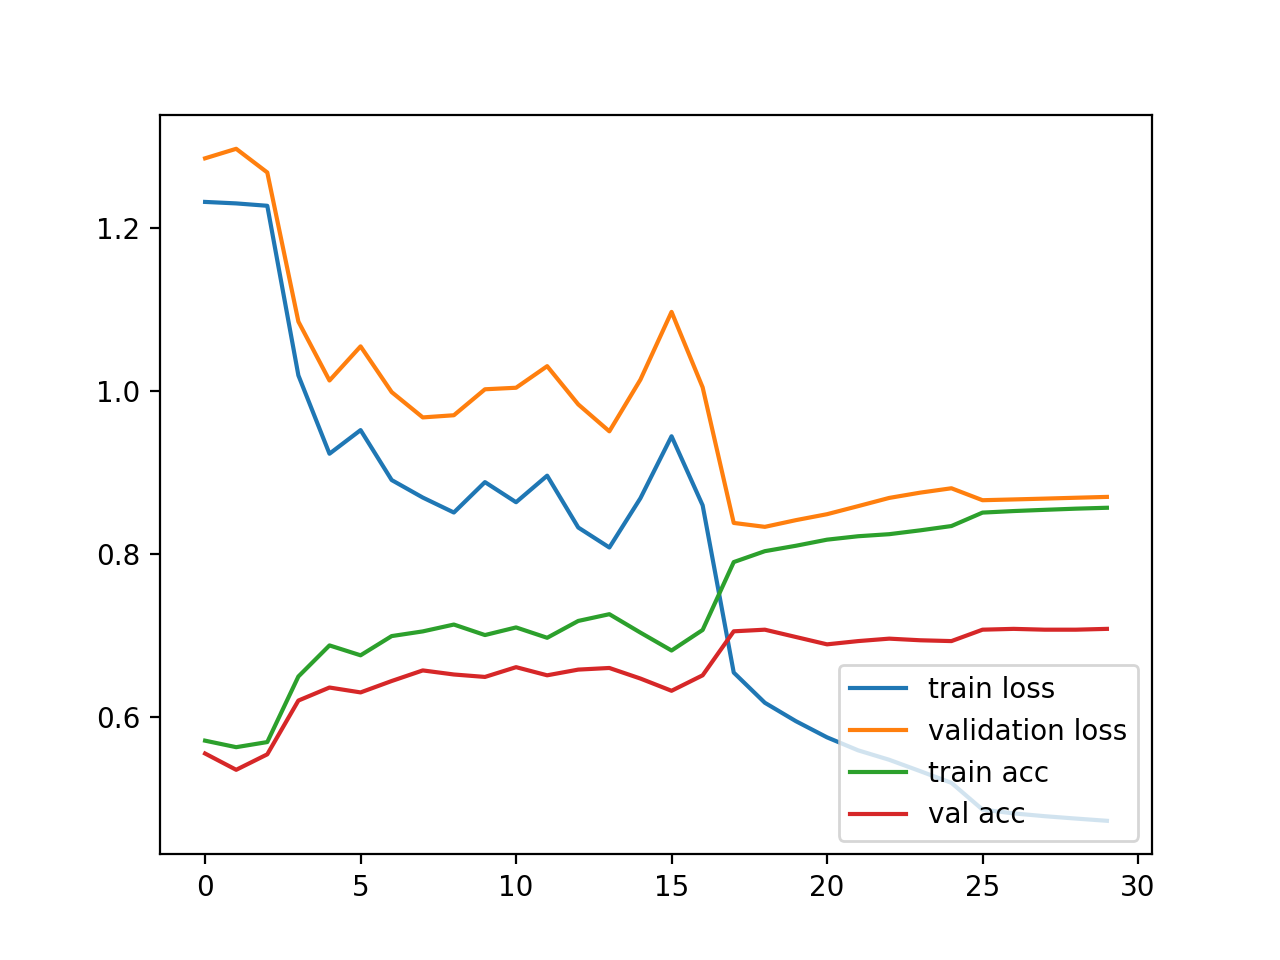

In [31]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend(loc='lower right')
plt.show()


plt.plot(train_acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.legend(loc='lower right')
plt.show()

### Don't forget the validation set!

And note that you can use the check_accuracy function to evaluate on either the test set or the validation set, by passing either **loader_test** or **loader_val** as the second argument to check_accuracy. You should not touch the test set until you have finished your architecture and hyperparameter tuning, and only run the test set once at the end to report a final value. 

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model).  This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [30]:
best_model = gpu_model
check_accuracy(best_model, loader_test, 'test')

Checking accuracy on  test


/home/deep/miniconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/deep/miniconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/deep/miniconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Got 6863 / 10000 correct (68.63)
loss tensor(0.9334, device='cuda:0')


(tensor(0.9334, device='cuda:0'), 0.6863)